# Introduction to Unsupervised Deep Learning Registration

[Adrian Dalca](http://adalca.mit.edu) for the [learn2reg 2019 tutorial](http://learn2reg.github.io)

Unsupervised is also often referred to end-to-end/self-supervised

### Outline
- **Core concepts with MNIST**   
We will first learn to deal with data, building a model, training, registration and generalization
- **More realistic complexity: Brain MRI (2D slices)**  
We will then show how these models work for 2d slices of brain scans, presenting a more complex scenario    
- **Realistic 3D Brain MRI**  
We will illustrate full 3D registration
- **Advances topics**  
Finally, we close with more advanced topics, including diffeomorphisms and fine-tuning deformations

Throughout this tutorial we assume that the images have been rigidly aligned in a (roughly) similar space.  
Rigid alignment is also possible with unsupervised learning-based registration, but it's not our focus here.  

### References
A good chunk of this tutorial build on work from [voxelmorph](https://github.com/voxelmorph/voxelmorph) ([TMI](https://arxiv.org/abs/1809.05231) and [MedIA](https://arxiv.org/abs/1903.03545)) and code from [neuron](https://github.com/adalca/neuron) ([CVPR](http://arxiv.org/abs/1903.03148))

---

# Preamble
## Setup of environment

We'll start with some common imports  

In [1]:
# imports
import os, sys

# third party imports
import numpy as np
import keras.layers

Using TensorFlow backend.


Next, we import two packages that will help us   
- [neuron](https://github.com/adalca/neuron) is a library for medical image analysis with tensorflow  
- [voxelmorph](http://voxelmorph.mit.edu) is a deep-learning based registration library  

In [2]:
# local imports.
sys.path.append('./voxelmorph/ext/pynd-lib')
sys.path.append('./voxelmorph/ext/pytools-lib')
sys.path.append('./voxelmorph/ext/neuron')
sys.path.append('./voxelmorph/')
import neuron
import voxelmorph as vxm

---

In [3]:
# # some manual parameters
# gpu_id = 7

# # gpu handling
# gpu = '/gpu:' + str(gpu_id)
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
# config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allow_growth = True
# set_session(tf.Session(config=config))

---

# Data

We're going to start by registering 2D MNIST digits, and then move on to medical data later.  
If the data is small (like 2D MNIST), you can often load it in memory, which enables for faster training and testing.  
If the data is large (large 3D scans), we will need to load the scans on demand. More on this later...

First, we're going to **load the data**  
Luckily, MNIST comes with the keras framework, so we can just load it here as follows



In [4]:
# import
# You should most often have this import together with all other imports at the top, 
# but we include here here explicitly to show where data comes from
from keras.datasets import mnist

In [5]:
# load the data. 
# `mnist.load_data()` already splits our data into train and test.  
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==5, ...]
y_train = y_train_load[y_train_load==5]
x_test = x_test_load[y_test_load==5, ...]
y_test = y_test_load[y_test_load==5]

# let's get some shapes to understand what we loaded.
print('shape of x_train: ', x_train.shape)
print('shape of y_train: ', y_train.shape)

shape of x_train:  (5421, 28, 28)
shape of y_train:  (5421,)


Note that separating your data in *only* train/test **often leads to problems**   
You wouldn't want to iteratively (A) build a model, (B) train on training data, and (C) test on test data  
Doing so will **overfit to you test set** (because you will have adapted your algorithm to your test data  

We will split the 'training' into 'train/validate' data, and keep the test set for later  
And will only look at the test data at the very end (once we're ready to submit the paper!)  

In [6]:
nb_val = 1000 # keep 10,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

### Visualize Data

Believeing we are done loading, it's always great to visualize the data  
Here, we use some tools from a package called `neuron`, which uses matplotlib  
You could use matplotlib as well directly, but it would just be a bit messier  
and here we want to illustrate the main concepts.  

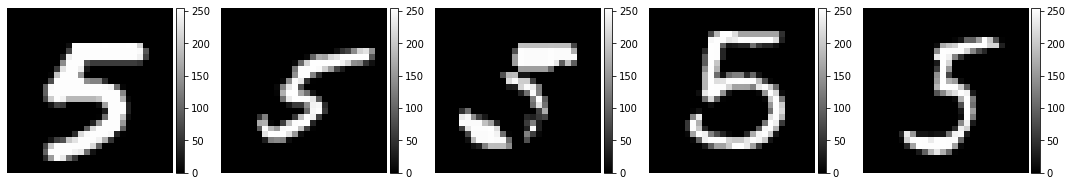

In [7]:
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
neuron.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

Looks good!  

However, luckily we included a **colorbar**, which shows us that the data is in [0, 255].  
In neural networks it's often great to work in the ranges of [0, 1] or [-1, 1] or around there.  
Let's fix this. 

In general, you should always plot your data with colorbars, which helps you catch issues before training  

In [8]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


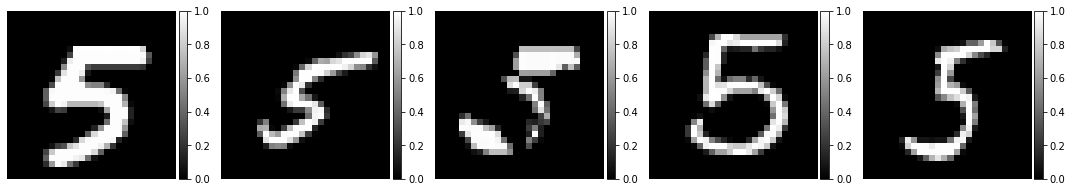

In [9]:
# re-visualize
example_digits = [f for f in x_train[idx, ...]]
neuron.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

One last change. Later on, we'll see that some of the most popular models  
like to have inputs that are sized as multiples of 2^N for N being the number of layers  
Here, we force our images to be size 32 (2x 2^4)

In [10]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of training data (892, 32, 32)


---

# CNN Model

Given two images, out goal is to find the deformation between them  

In learning-based methods, we use a network that takes in two images $m$ and $f$ (e.g. MNIST digits of size 32x32)    
and outputs a dense deformation $\phi$ (e.g. size 32x32x2, because at each pixel we want a vector telling us where to go)  

**Note**: registration also includes (or refers to) affine transforms, but we ignore that here  

We're going to abstract the UNet for this tutorial and use a function from [voxelmorph](http://voxelmorph.mit.edu)  
`vxm.networks.unet_core()` enables this

In [11]:
ndims = 2
vol_shape = x_train.shape[1:]
nb_enc_features = [32, 32, 32, 32]
nb_dec_features = [32, 32, 32, 32, 32, 16]

In [12]:
# first, let's get a unet (before the final layer)
unet = vxm.networks.unet_core(vol_shape, nb_enc_features, nb_dec_features);

let's explore the model bit

In [13]:
# inputs
print('numer of inputs', len(unet.inputs))
moving_input_tensor = unet.inputs[0]
fixed_input_tensor = unet.inputs[1]
    
# output
print('output:', unet.output)

numer of inputs 2
output: Tensor("leaky_re_lu_10/LeakyRelu:0", shape=(?, 32, 32, 16), dtype=float32)


okay, we need to make sure the final output has 2 features,  
representing the deformation at each voxel

In [14]:
# transform the results into a flow field.
disp_tensor = keras.layers.Conv2D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)

# check
print('displacement tensor:', disp_tensor)


displacement tensor: Tensor("disp/BiasAdd:0", shape=(?, 32, 32, 2), dtype=float32)


In [15]:
# a cool aspect of keras is that we can easily form new models via tensor pointers:
def_model = keras.models.Model(unet.inputs, disp_tensor)
# def_model will now *share layers* with the UNet -- if we change layer weights 
# in the UNet, they change in the def_model 

### Loss

Given that the displacement $\phi$ is output from the network,  
we need to figure out a loss to tell if it makes sense

In a **supervised setting** we would have ground truth deformations $\phi_{gt}$,  
and we could use a supervised loss like MSE $= \| \phi - \phi_{gt} \|$

The main idea in **unsupervised registration** is to use loss inspired by classical registration  

Without supervision, how do we know this deformation is good?  
(1) make sure that $m \circ \phi$ ($m$ warped by $\phi$) is close to $f$  
(2) regularize $\phi$ (often meaning make sure it's smooth)  

To achieve (1), we need to *warp* input image $m$.  
To do this, we use a spatial transformation network layer, which essentially does linear interpolation  
This layer is defined in [neuron](https://github.com/adalca/neuron)

In [16]:
spatial_transformer = neuron.layers.SpatialTransformer(name='spatial_transformer')

# warp the image
moved_image_tensor = spatial_transformer([moving_input_tensor, disp_tensor])

To make sure the moved_image is close to the fixed image, and  
to achieve smoothness loss of $\phi$ in (2), we will want these two as outputs from the full model 

In [17]:
inputs = [moving_input_tensor, fixed_input_tensor]
outputs = [moved_image_tensor, disp_tensor]
vxm_model = keras.models.Model(inputs, outputs)

Finally, let's define the actual loss. The way keras works, we need to define a loss for each output.    
The first loss is easy, it's simply MSE between the warped image $m \circ \phi$.
For the second, we will use a spatial gradient of the displacement.  
We won't code this from scratch here, but we'll use the `voxelmorph` implementation.

In [18]:
# losses. Keras recognizes the string 'mse' as mean squared error, so we don't have to code it
losses = ['mse', vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter.
lambda_param = 0.05
loss_weights = [1, lambda_param]

Finally, we can compile the model. 
This sets up the model for training, by associating the model with a loss and an optimizer

In [19]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train Model

To train, we need to make sure the data is in the right format and fed to the model the way we want it  
keras models can be trained with `model.fit`, which requires all the data to be in a big array, or `model.fit_generator`, which requires a python generator that gives you batches of data

Let's code a simple data generator based on the MNIST data

In [20]:
def vxm_data_generator(x_data, batch_size=32):
    """
    generator that takes in data of size [N, H, W], and yields data for our vxm model
    
    Note that we need to provide numpy data for each input, and each output
    
    inputs:  moving_image [bs, H, W, 1], fixed_image [bs, H, W, 1]
    outputs: moved_image  [bs, H, W, 1], zeros [bs, H, W, 2]
    """
    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation. We'll explain this below.
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs
        # inputs need to be of the size [batch_size, H, W, number_features]
        #   number_features at input is 1 for us
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # outputs
        # we need to prepare the "true" moved image.  
        # Of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield inputs, outputs        

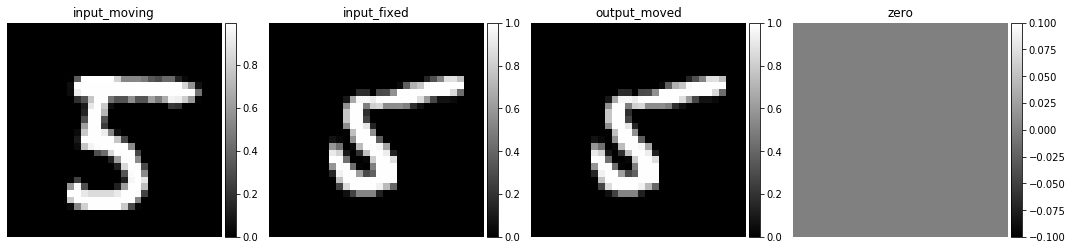

In [21]:
# let's test it
train_generator = vxm_data_generator(x_train)
input_sample, output_sample = next(train_generator)

# visualize
slices_2d = [f[0,...,0] for f in input_sample + output_sample]
titles = ['input_moving', 'input_fixed', 'output_moved', 'zero']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

In [22]:
nb_epochs = 10
steps_per_epoch = 10
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
 - 4s - loss: 0.0747 - spatial_transformer_loss: 0.0730 - disp_loss: 0.0346
Epoch 2/10
 - 2s - loss: 0.0612 - spatial_transformer_loss: 0.0577 - disp_loss: 0.0695
Epoch 3/10
 - 1s - loss: 0.0507 - spatial_transformer_loss: 0.0460 - disp_loss: 0.0940
Epoch 4/10
 - 1s - loss: 0.0437 - spatial_transformer_loss: 0.0386 - disp_loss: 0.1023
Epoch 5/10
 - 1s - loss: 0.0382 - spatial_transformer_loss: 0.0331 - disp_loss: 0.1013
Epoch 6/10
 - 2s - loss: 0.0358 - spatial_transformer_loss: 0.0308 - disp_loss: 0.0988
Epoch 7/10
 - 1s - loss: 0.0335 - spatial_transformer_loss: 0.0285 - disp_loss: 0.1011
Epoch 8/10
 - 1s - loss: 0.0295 - spatial_transformer_loss: 0.0248 - disp_loss: 0.0941
Epoch 9/10
 - 1s - loss: 0.0311 - spatial_transformer_loss: 0.0259 - disp_loss: 0.1041
Epoch 10/10
 - 1s - loss: 0.0277 - spatial_transformer_loss: 0.0226 - disp_loss: 0.1033


It's always a good idea to visualize the loss, not just read off the numbers  
This will give us a better idea of whether it's converged, etc.  
Tensorflow offers a powerful interactive system for visualizing called tensorboard  
For this short tutorial, we will simply plot the loss

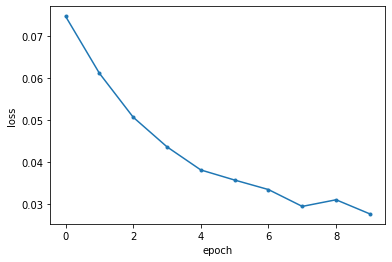

In [23]:
# as with other imports, this import should be at the top, or use notebook matplotlib magic
# we keep it here to be explicit why we need it
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    """
    Quick function to plot the history 
    """
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

# Registration

With pair-wise optimization methods (like most classical methods),  
to register a new pair you would need to optimize a deformation field.  

With learning based registration, we simply evaluate the network for a new input pair  

In [24]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

*Registration*: `predict()` essentially executes the network given an input.

In [25]:
val_pred = vxm_model.predict(val_input)

and that's it! 

Even though this is on MNIST only, let's see how long this takes

In [26]:
# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

2.94 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


~30ms per registration is quite fast, even for MNIST.  
Let's visualize the results

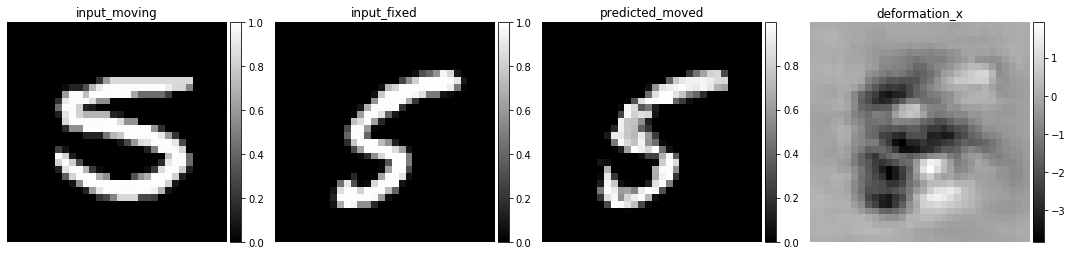

In [27]:
# visualize
slices_2d = [f[0,...,0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

Let's visualize the flow a bit better

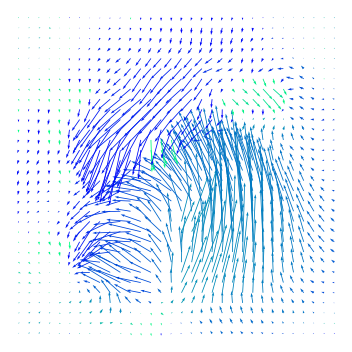

In [28]:
neuron.plot.flow([val_pred[1].squeeze()], width=5);

# Generalization 
How do learning-based methods generalize beyond training distribution ?

An important caveat to learning-based registration is that  
They will, in general, only register samples fromt he distribution they've been trained from  

So, what happens if we register two 7s?

In [29]:
# extract only instances of the digit 5
x_sevens = x_train_load[y_train_load==7, ...].astype('float')/255
x_sevens = np.pad(x_sevens, pad_amount, 'constant')

seven_generator = vxm_data_generator(x_sevens, batch_size=1)
seven_sample, _ = next(seven_generator)
seven_pred = vxm_model.predict(seven_sample)

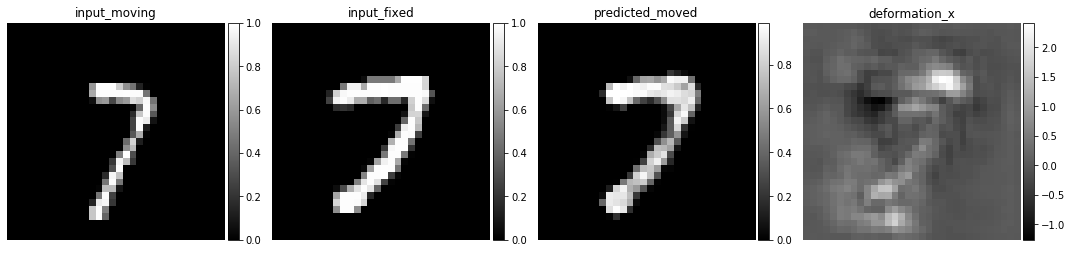

In [30]:
# visualize
slices_2d = [f[0,...,0] for f in seven_sample + seven_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

interesting, it still works! So it **generalized beyond what we expected**. Why?  
Locally, parts of the 7s look similar to the 5s, so the  registration algorithm still tries to match local neighborhoods.

Let's try a different variation.  
What if we just modify the (original) set, but multiplied the intensities by a factor?

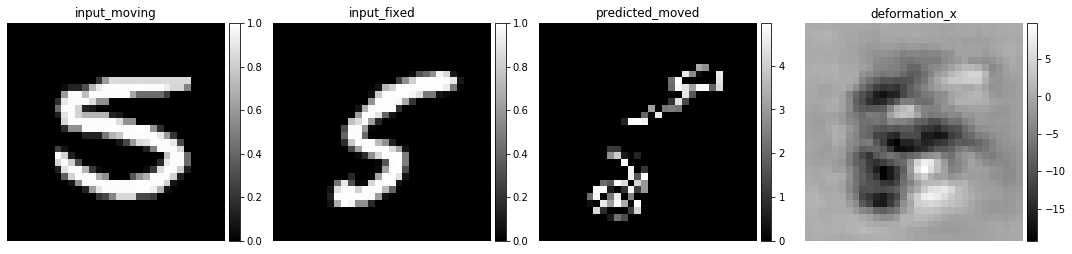

In [31]:
factor = 5
val_pred = vxm_model.predict([f*factor for f in val_input])

# visualizeb
slices_2d = [f[0,...,0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

This broke down! Why? In this case, the network has never seen even parts of this image.  

Understanding when the network generalizes and when it does not is very important, and still a part of active research  

---

# Registration of Brain MRI

We will now register slightly more realistic data: MRIs of the brain.  
To be able to train and easily register during this tutorial,  
we will first extract the middle slice of brain scans. 

Nothat because this task does not capture deformations in the third dimensions,  
certain  correspondances are not exactly possible.  Nonetheless, this exercise  
will illustrate registration with more realistic complex images.   

The brains have been intensity-normalized affinely aligned, and skull stripped  
with FreeSurfer, to enable focusing on deformable registration  

In [32]:
# we've prepared the data in the following files
# prepared as N x H x W
core_path = './data/slice-100'
x_train = np.load(os.path.join(core_path, 'train_vols.npy'))
x_val = np.load(os.path.join(core_path, 'validate_vols.npy'))
x_test = np.load(os.path.join(core_path, 'test_vols.npy'))

vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


The 208 volumes are of size `160x192`.  
Let's look at some

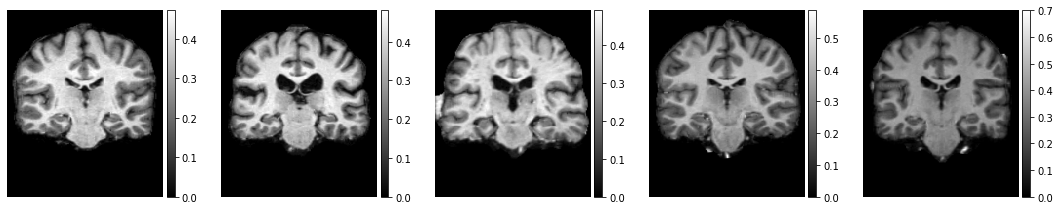

In [33]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
neuron.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

### Model

As before, we create a model based on a unet, plus a spatial transformer

In [34]:
# unet
unet = vxm.networks.unet_core(vol_shape, nb_enc_features, nb_dec_features);
disp_tensor = keras.layers.Conv2D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)

# spatial transfomer
spatial_transformer = neuron.layers.SpatialTransformer(name='image_warping')
moved_image_tensor = spatial_transformer([unet.inputs[0], disp_tensor])

# final model
vxm_model = keras.models.Model(unet.inputs, [moved_image_tensor, disp_tensor])

As with MNIST, we'll start with losses of 'mse' and spatial smoothing

In [35]:
# losses. Keras recognizes the string 'mse' as mean squared error, so we don't have to code it
losses = ['mse', vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter.
lambda_param = 0.01
loss_weights = [1, lambda_param]

from experimentation, we have found the Adam optimizer learning rate of `1e-4`  
performs better than `1e-3` for this problem. 

In [36]:
vxm_model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

Luckily, we can use the same generator as before, since we're using the same format.  
Let's test it first

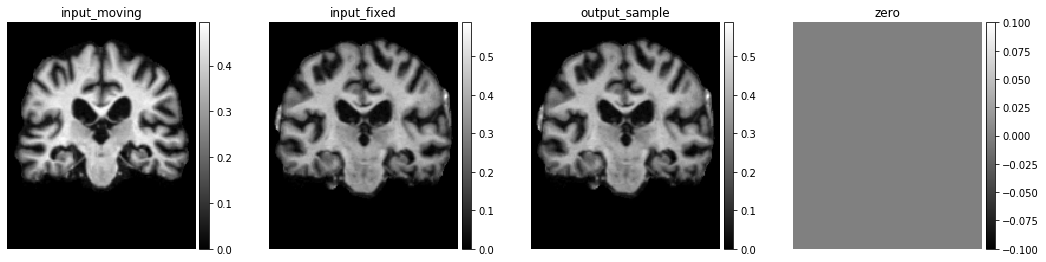

In [37]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
input_sample, output_sample = next(train_generator)

# visualize
slices_2d = [f[0,...,0] for f in input_sample + output_sample]
titles = ['input_moving', 'input_fixed', 'output_sample', 'zero']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

Looks good, time to **train the model**

In [38]:
nb_epochs = 10
steps_per_epoch = 3

In [39]:
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10
 - 6s - loss: 0.0071 - image_warping_loss: 0.0070 - disp_loss: 0.0018
Epoch 2/10
 - 3s - loss: 0.0069 - image_warping_loss: 0.0068 - disp_loss: 0.0018
Epoch 3/10
 - 3s - loss: 0.0068 - image_warping_loss: 0.0068 - disp_loss: 0.0018
Epoch 4/10
 - 3s - loss: 0.0064 - image_warping_loss: 0.0064 - disp_loss: 0.0019
Epoch 5/10
 - 2s - loss: 0.0065 - image_warping_loss: 0.0065 - disp_loss: 0.0019
Epoch 6/10
 - 2s - loss: 0.0071 - image_warping_loss: 0.0070 - disp_loss: 0.0018
Epoch 7/10
 - 2s - loss: 0.0067 - image_warping_loss: 0.0067 - disp_loss: 0.0018
Epoch 8/10
 - 2s - loss: 0.0080 - image_warping_loss: 0.0080 - disp_loss: 0.0019
Epoch 9/10
 - 2s - loss: 0.0071 - image_warping_loss: 0.0071 - disp_loss: 0.0017
Epoch 10/10
 - 2s - loss: 0.0062 - image_warping_loss: 0.0061 - disp_loss: 0.0017


In [40]:
# for the purpose of the tutorial we ran very few epochs.  
# Here we load a model that was run for 10 epochs and 100 steps per epochs
vxm_model.load_weights('models/brain_2d_shortrun.h5')

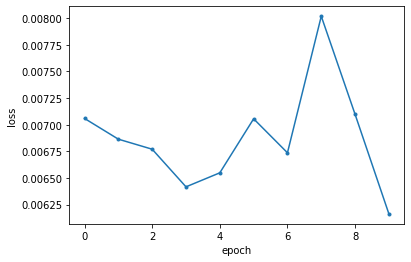

In [41]:
# as before, let's visualize what happened
plot_history(hist)

let's see some results

In [42]:
val_generator = vxm_data_generator(x_val, batch_size = 1)

In [43]:
val_input, _ = next(val_generator)

In [44]:
val_pred = vxm_model.predict(val_input)

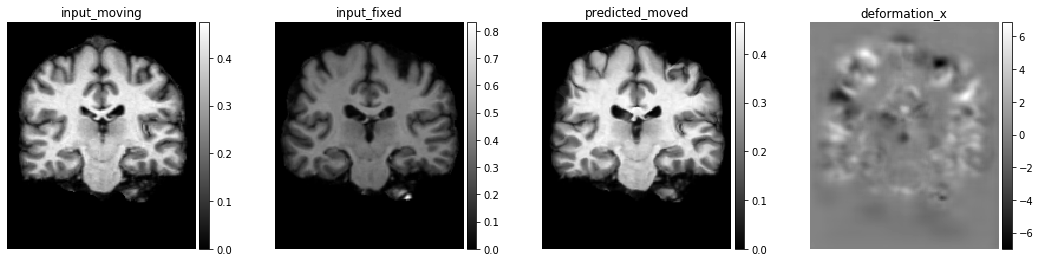

In [45]:
# visualize
slices_2d = [f[0,...,0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

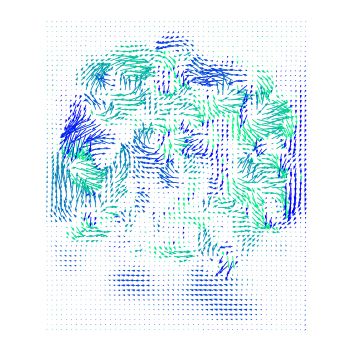

In [46]:
flow = val_pred[1].squeeze()[::3,::3]
neuron.plot.flow([flow], width=5);

let's save out model weights, we'll use them in a bit

In [47]:
vxm_model.save_weights('models/brain_2d_shortrun.h5')

# Evaluation

Evaluating registration results is tricky.  
The first tendancy is to look at the images (as above),  
and conclude that if they match, The registration has succeeded. 

However, this can be achieved by an optimization that only penalizes the image matching term  
For example, in the next cell we compare our model with one that wastrained on maximizing MSE only (no smoothness loss)

In [48]:
vxm_model.load_weights('models/brain_2d_shortrun.h5')
our_val_pred = vxm_model.predict(val_input)

vxm_model.load_weights('models/brain_2d_mseonly.h5')
mse_val_pred = vxm_model.predict(val_input)

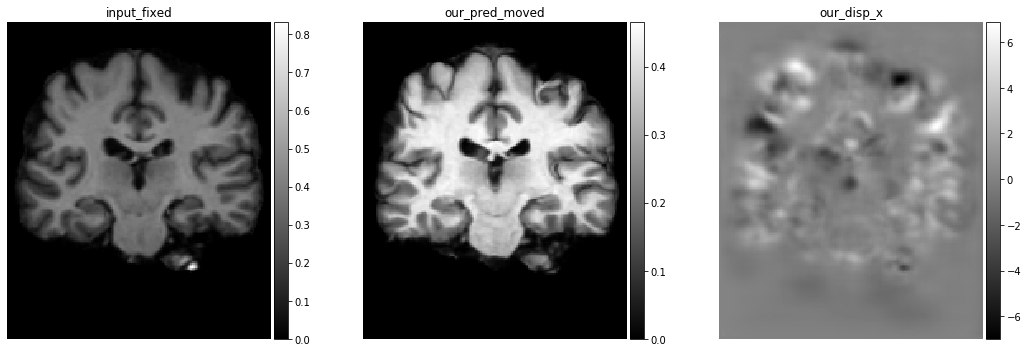

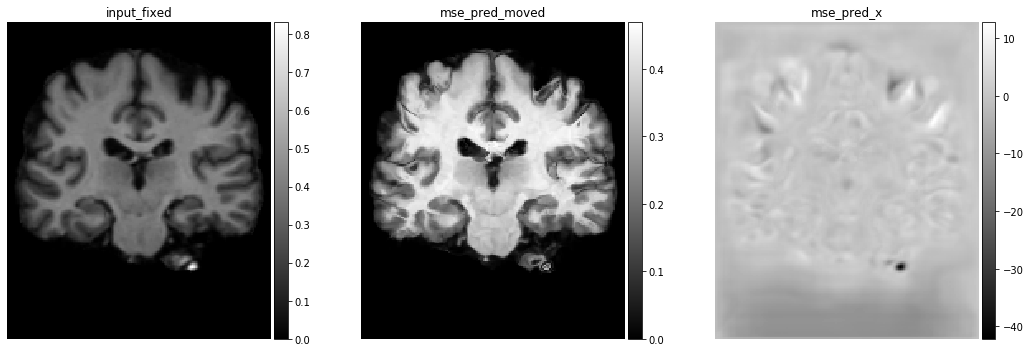

In [49]:
# visualize both models
slices_2d = [f[0,...,0] for f in [val_input[1]] + our_val_pred ]
titles = ['input_fixed', 'our_pred_moved', 'our_disp_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize both models
slices_2d = [f[0,...,0] for f in [val_input[1]] + mse_val_pred]
titles = ['input_fixed', 'mse_pred_moved', 'mse_pred_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

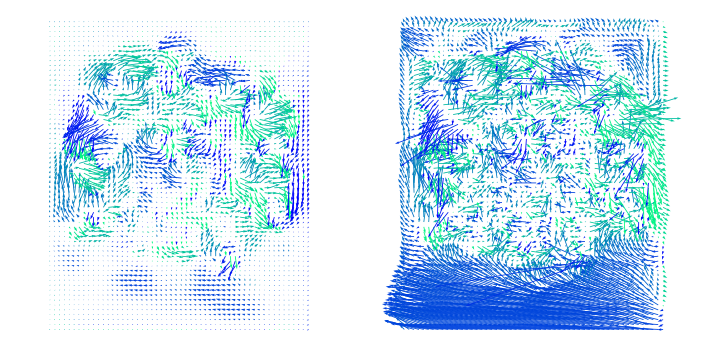

In [50]:
neuron.plot.flow([f[1].squeeze()[::3,::3] for f in [our_val_pred, mse_val_pred]], width=10);

At first look, the mse-only model matches the fixed image better  
But we can see that it obtains a deformation field that is very noisy, unlikely to be anatomically meaningful  

What we often do isntead of use **external anotations** for evaluation  
One way is using anatomical segmentations.  

In the next section, we demonstrate the use of a 3D model, and show how to evaluate it with segmentations 

---

# 3D MRI brain scan registration

Finally, we get to 3D models, which are of particular interest in medical image analysis. 

However, due to the size of the models and data, we won't be able to train a model  
within a short tutorial time. Instead, here we assume one has been trained, and demonstrate its use.
You can train one very similar to how you trained the 2D models above.

### Model

In [51]:
# our data will be of shape 160 x 192 x 224
vol_shape = [160, 192, 224]
ndims = 3

In [52]:
nb_enc_features = [16, 32, 32, 32]
nb_dec_features = [32, 32, 32, 32, 32, 16, 16]

In [53]:
# unet
unet = vxm.networks.unet_core(vol_shape, nb_enc_features, nb_dec_features);
disp_tensor = keras.layers.Conv3D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)

# spatial transfomer
spatial_transformer = neuron.layers.SpatialTransformer(name='image_warping')
moved_image_tensor = spatial_transformer([unet.inputs[0], disp_tensor])

# final model
vxm_model = keras.models.Model(unet.inputs, [moved_image_tensor, disp_tensor])

### Validation data

In [54]:
val_volume_1 = np.load('data/3D/subject_1_vol.npz')['vol_data']
seg_volume_1 = np.load('data/3D/subject_1_seg.npz')['vol_data']
val_volume_2 = np.load('data/3D/atlas_norm_3d.npz')['vol']
seg_volume_2 = np.load('data/3D/atlas_norm_3d.npz')['seg']


val_input = [val_volume_1[np.newaxis, ..., np.newaxis], val_volume_2[np.newaxis, ..., np.newaxis]]

Load a trained 3D model

In [55]:
vxm_model.load_weights('models/cvpr2018_vm2_cc.h5')

Let's register

In [56]:
val_pred = vxm_model.predict(val_input);

In [57]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

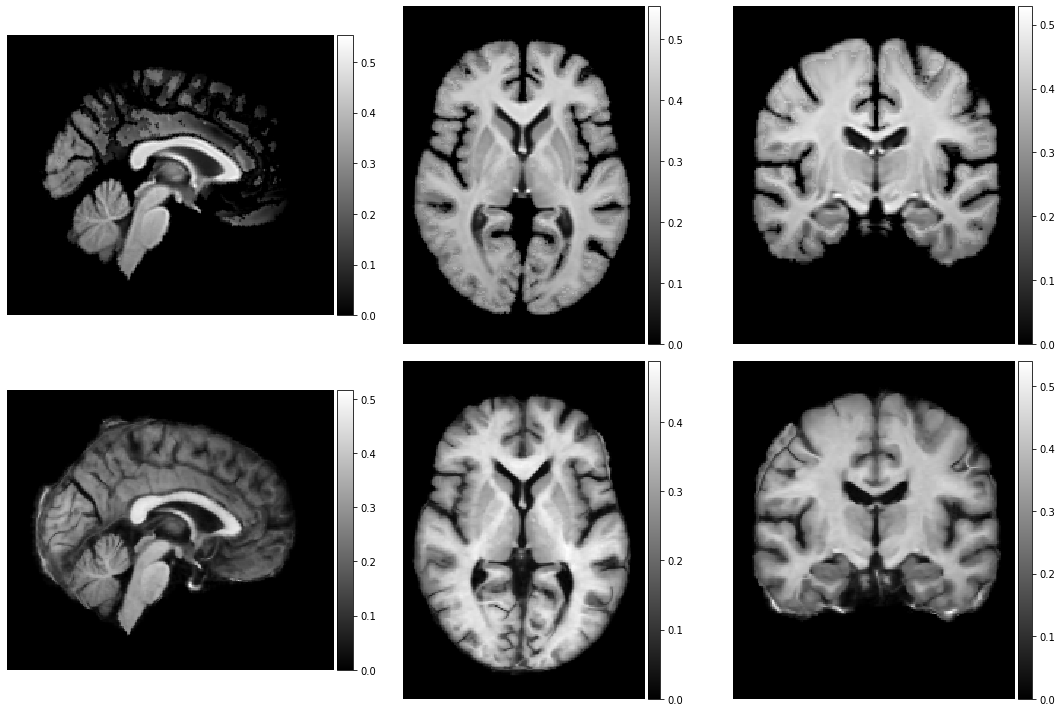

In [58]:
mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(ndims)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(ndims)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
neuron.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

Let's look at the segmentations! To do this, we'll need to warp segmentations. 

In [59]:
warp_model = vxm.networks.nn_trf(vol_shape)

In [60]:
warped_seg = warp_model.predict([seg_volume_1[np.newaxis,...,np.newaxis], pred_warp])

We're first going to prepare a colormap

In [61]:
from pytools import plotting as pytools_plot
import matplotlib

[ccmap, scrambled_cmap] = pytools_plot.jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

Let's visualize the segmentations, and essentially make sure they are not crazy

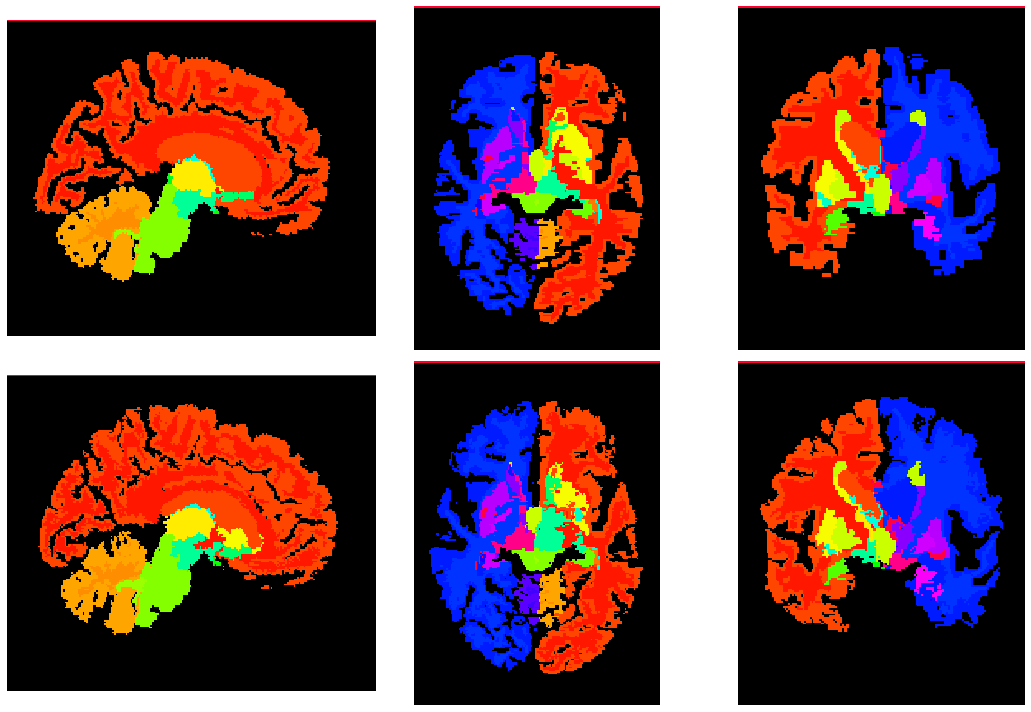

In [62]:
mid_slices_fixed = [np.take(seg_volume_1, vol_shape[d]//1.8, axis=d) for d in range(ndims)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(ndims)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

slices = mid_slices_fixed + mid_slices_pred
for si, slc  in enumerate(slices):
    slices[si][0] = 255
neuron.plot.slices(slices, cmaps = [ccmap], grid=[2,3]);

## runtime

An important advantage of learning-based methods is the dramatically lowered runtime

In [63]:
%timeit vxm_model.predict(val_input)

13 s ± 819 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In our tests, a run is 10s, for an entire 3D volume.  
Classically, this would take hours.